# Introduction 

## Tổng quan về bộ dữ liệu 

- Bộ dữ liệu này là sự kết hợp của ba nguồn: figshare, SARTAJ dataset, và Br35H. Nó bao gồm 7.023 hình ảnh MRI não người, được phân loại thành 4 nhóm chính: glioma, meningioma, no tumor (không có khối u), và pituitary.
- Tổng số lượng hình ảnh: 7.023 ảnh MRI não người, chia thành 4 nhóm chính:
    1. **Glioma**: U ác tính trong tế bào thần kinh đệm.
    2. **Meningioma**: U lành tính phát triển từ màng não.
    3. **No Tumor**: Ảnh quét não bình thường, không có khối u (lấy từ Br35H).
    4. **Pituitary**: U tuyến yên (có thể lành hoặc ác tính).
 
- Hình ảnh trong bộ dữ liệu có kích thước khác nhau. Để đạt hiệu quả tốt hơn, cần:
  1. Tiền xử lý: Loại bỏ viền dư thừa.
  2. Resize hình ảnh về cùng kích thước trước khi huấn luyện mô hình.
- Mục tiêu: Ứng dụng bộ dữ liệu trong việc phân loại ảnh theo loại (glioma, meningioma, pituitary, no tumor) và cấp độ ác tính.

- Kích thước dữ liệu (bao gồm 2 tập Training + Testing):
- **Tập training** : glioma 
132files, meningioma a

files, iles
n umorfiles, 5 files
 tuitary

- **Tập Testing**: glioma 300 files, meningioma 300 files, notumor 405 files, pituitary 300 files
300 files
1457 files

# Data Preprocessing

## Get Data

In [1]:
!pip install -q lightning onnxruntime

In [2]:
import torch 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import lightning as pl

In [3]:
from PIL import Image
import os

In [4]:
DATA_PATH = '/kaggle/input/brain-tumor-mri-dataset'
TRAIN_PATH = DATA_PATH + '/Training'
TEST_PATH = DATA_PATH + '/Testing'

## EDA

- Phân bố các nhãn dữ liệu 

In [5]:
def plot_pie(counts): 
    plt.figure(figsize=(8, 8))
    plt.pie(
        list(counts.values()), 
        labels=list(counts.keys()), 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors
    )
    plt.title("Phân bố các trường dữ liệu")
    plt.show()
    

In [6]:
import os 

def count_data(path: str): 
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    counts = {}

    for root, dirs, files in os.walk(path): 
        name = str(root.split("/")[-1]) 
        
        if files != [] and name in classes: 
            counts[name] = len(files)
    return counts 

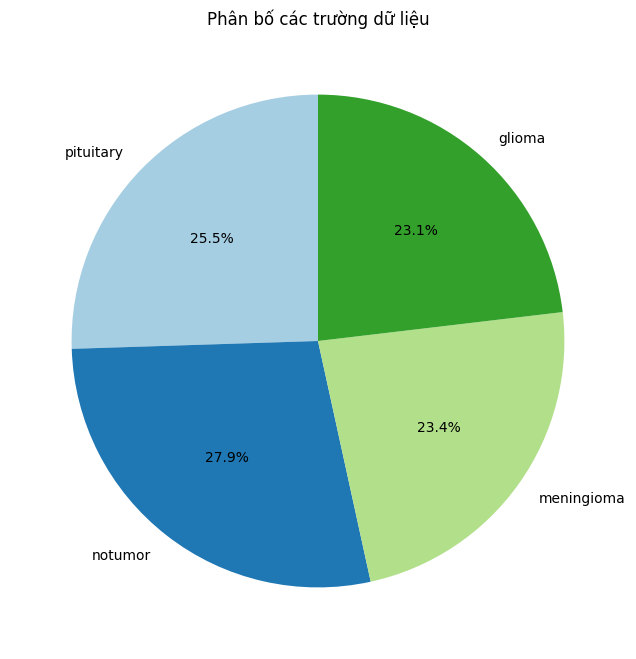

In [7]:
count_training = count_data(TRAIN_PATH)
plot_pie(count_training)

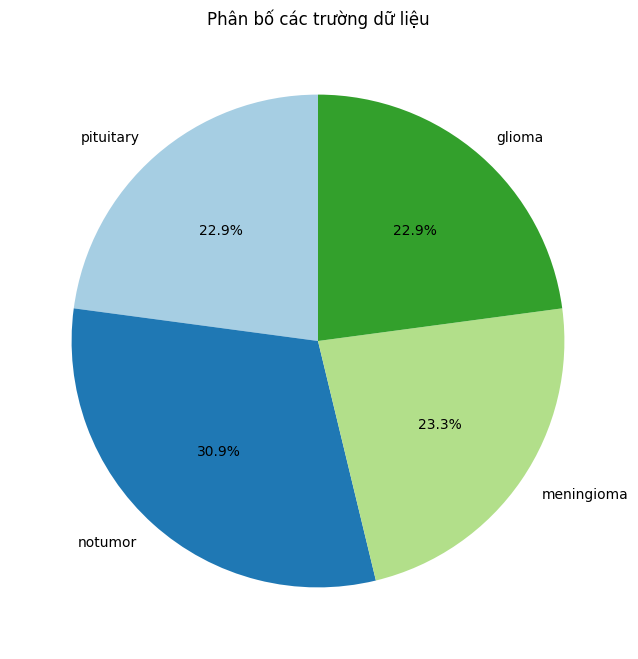

In [8]:
count_testing = count_data(TEST_PATH)
plot_pie(count_testing)

=> Phân bố dữ liệu đồng đều AttributeError

- Kích thước ảnh 

In [9]:
from PIL import Image

def get_image_sizes(folder_path):
    image_sizes = []  
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        image_sizes.append((width, height))
                except Exception as e:
                    print(f"Lỗi đọc ảnh {file_path}: {e}")
    return image_sizes

In [10]:
def plot_img_size(image_sizes, data_name): 
    widths, heights = zip(*image_sizes)  
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.6, edgecolor='k')
    plt.title(f'Kích thước ảnh (Width x Height) của {data_name}', fontsize=14)
    plt.xlabel('Chiều rộng (Width)', fontsize=12)
    plt.ylabel('Chiều cao (Height)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

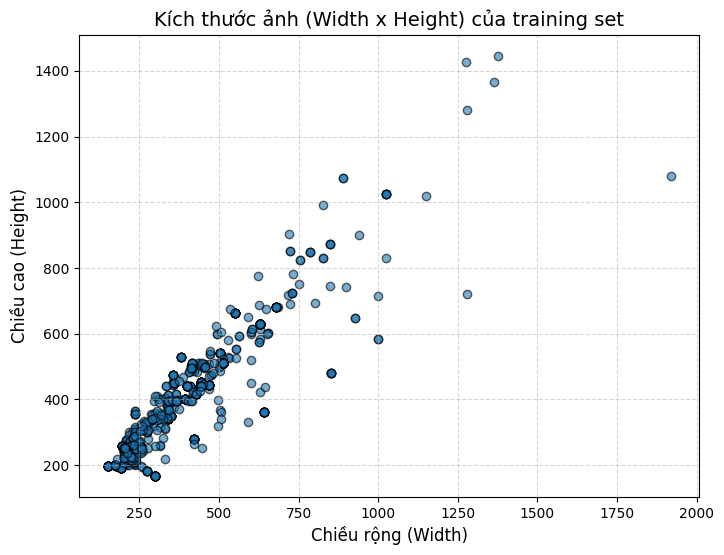

In [11]:
training_image_sizes = get_image_sizes(TRAIN_PATH)
plot_img_size(training_image_sizes, "training set")

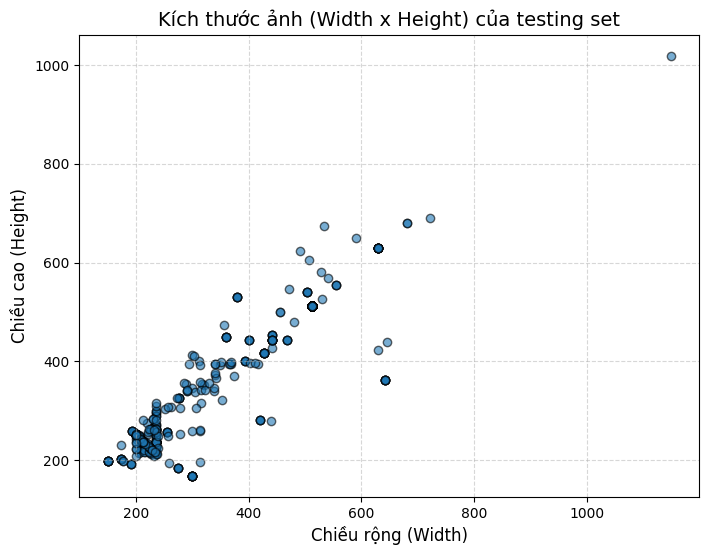

In [12]:
testing_image_sizes = get_image_sizes(TEST_PATH)
plot_img_size(testing_image_sizes, "testing set")

- Visualize một số điểm dữ liệu 

In [13]:
import random

def get_category_images(folder_path):
    category_images = {}
    for root, _, files in os.walk(folder_path):
        category = os.path.basename(root)
        if category not in category_images:
            category_images[category] = []
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                category_images[category].append(os.path.join(root, file))
    return category_images


In [14]:
def plot_random_images(category_images):
    selected_images = {}

    for category, images in category_images.items():
        if images: 
            selected_images[category] = random.choice(images)
    
    plt.figure(figsize=(12, 8))
    for i, (category, image_path) in enumerate(selected_images.items(), start=1):
        print(image_path)
        try:
            img = Image.open(image_path).convert('RGB')
            plt.subplot(2, 2, i)
            plt.imshow(img, )
            plt.title(category)
            plt.axis('off')
        except Exception as e:
            print(f"Không thể mở ảnh {image_path}: {e}")
    plt.tight_layout()
    plt.show()

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0577.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0472.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0574.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0745.jpg


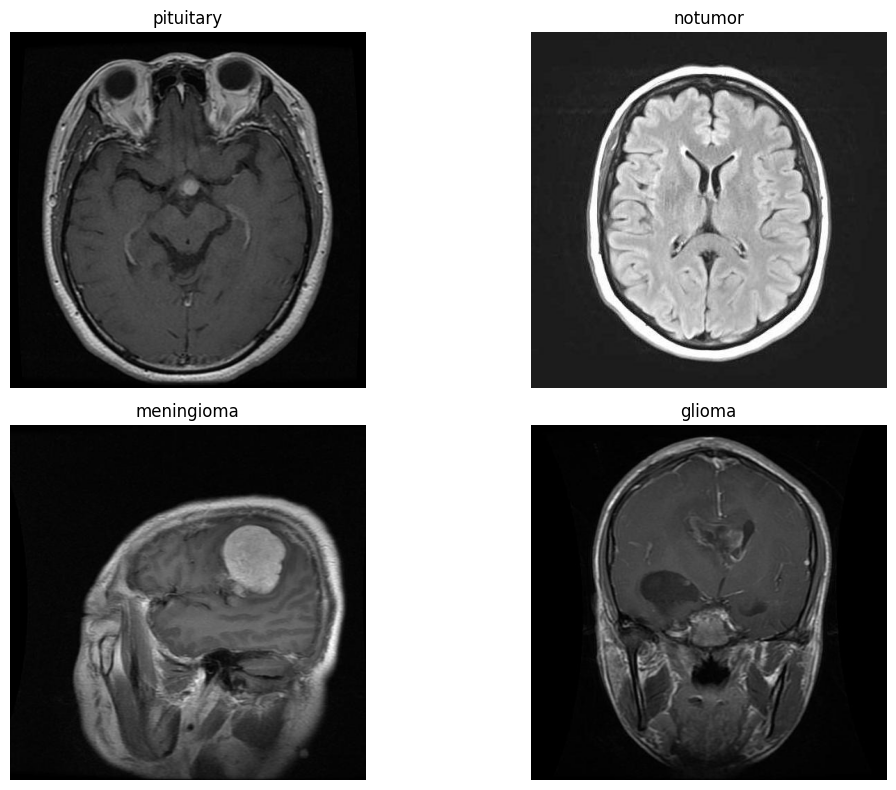

In [15]:
category_images = get_category_images(TRAIN_PATH)
plot_random_images(category_images)

## Data Transform

In [16]:
import os
def transform_data_to_dict(folder_path):
    image_dict = {} 
    index = 0

    for root, _, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                image_dict[index] = {'path': file_path, 'label': label}
                index += 1
    return image_dict

In [17]:
train_dict = transform_data_to_dict(TRAIN_PATH)
test_dict = transform_data_to_dict(TEST_PATH)

In [18]:
len(train_dict)

5712

In [19]:
len(test_dict)

1311

In [20]:
train_dict[0]

{'path': '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg',
 'label': 'pituitary'}

## Dataset 

In [21]:
# visualize 
from torch.utils.data import Dataset, DataLoader

class BrainTumourDataset(Dataset): 

    def __init__(self, data_dir: str, transform = None): 
        self.data_dict = transform_data_to_dict(data_dir)
        self.transform = transform 
        self.labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']
        

    def __getitem__(self, idx):
        datapoint = self.data_dict[idx]
        path = datapoint['path']
        label = self.labels.index(datapoint['label']) 

        img = Image.open(path).convert('RGB')
        if self.transform : img = self.transform(img)
        return img, label
            
        
    def __len__(self): 
        return len(self.data_dict)
    

In [22]:
# define transform 
from torchvision import transforms 

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Grayscale(),
                                     transforms.Resize((64,64))])

In [23]:
# define data loader 
import lightning as pl 


class BrainTumorDatamodule(pl.LightningDataModule): 

    def __init__(self, train_dir: str, test_dir: str, transform):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir 
        self.transform = transform 

    def setup(self, stage = None): 
        self.train_dataset = BrainTumourDataset(self.train_dir, self.transform)
        self.val_dataset = BrainTumourDataset(self.test_dir, self.transform)

    def train_dataloader(self): 
        return DataLoader(self.train_dataset, shuffle=True, batch_size= 64, num_workers=4)

    def val_dataloader(self): 
        return DataLoader(self.val_dataset, shuffle=True, batch_size=64, num_workers=4)


In [24]:
datamodule = BrainTumorDatamodule(TRAIN_PATH, TEST_PATH, data_transform)

datamodule.setup()

train_loader = datamodule.train_dataloader()

In [25]:
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"Inputs:\n{inputs}")
    print(f"Labels:\n{labels}")
    print("-" * 30)
    break 

Batch 1:
Inputs:
tensor([[[[1.0699e-02, 1.0590e-02, 1.4453e-02,  ..., 1.4893e-02,
           1.4158e-02, 1.4750e-02],
          [2.7174e-02, 2.8303e-02, 3.4642e-02,  ..., 2.8329e-02,
           3.1231e-02, 2.9683e-02],
          [3.6670e-02, 4.0225e-02, 3.8027e-02,  ..., 3.1428e-02,
           3.4535e-02, 3.0180e-02],
          ...,
          [3.8026e-02, 3.5827e-02, 3.7151e-02,  ..., 3.5468e-02,
           3.6059e-02, 3.6995e-02],
          [2.7151e-02, 2.9239e-02, 3.0562e-02,  ..., 3.4053e-02,
           3.5979e-02, 3.1027e-02],
          [5.8790e-03, 7.1517e-03, 9.5045e-03,  ..., 1.1868e-02,
           1.0850e-02, 1.0358e-02]]],


        [[[1.0703e-01, 1.0703e-01, 1.0382e-01,  ..., 1.0103e-01,
           1.0091e-01, 1.0508e-01],
          [1.1096e-01, 1.1072e-01, 1.0832e-01,  ..., 1.0703e-01,
           1.0686e-01, 1.0979e-01],
          [1.0906e-01, 1.0601e-01, 1.0560e-01,  ..., 1.1954e-01,
           1.1384e-01, 1.1130e-01],
          ...,
          [1.0845e-01, 1.0700e-01, 1.071

In [26]:
image_tensor = datamodule.train_dataset[0][0]
label =  datamodule.train_dataset.labels[datamodule.train_dataset[0][1]]

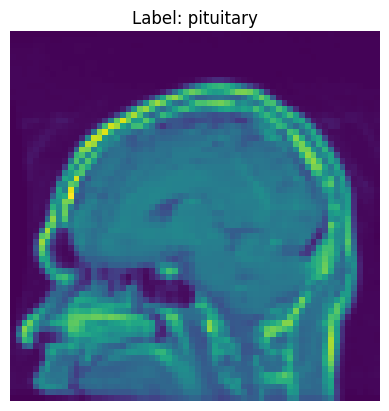

In [27]:
image = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.axis('off')  
plt.title(f"Label: {label}")
plt.show()

In [28]:
image_tensor

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0040, 0.0040, 0.0040],
         [0.0035, 0.0034, 0.0035,  ..., 0.0078, 0.0081, 0.0078],
         [0.0082, 0.0081, 0.0079,  ..., 0.0078, 0.0079, 0.0078],
         ...,
         [0.0204, 0.0201, 0.0214,  ..., 0.0092, 0.0113, 0.0126],
         [0.0113, 0.0091, 0.0089,  ..., 0.0081, 0.0085, 0.0120],
         [0.0008, 0.0007, 0.0003,  ..., 0.0040, 0.0041, 0.0046]]])

# Mô hình 

In [29]:
import torch.nn as nn 

class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Grayscale input
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x32x32
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x16x16
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x8x8
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x4x4
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),  # Adjusted to match new input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output: num_classes
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.fc(x)
        return x


In [30]:
import lightning as pl
from torchmetrics.classification import Accuracy, F1Score


class VGG16Lightning(pl.LightningModule):
    def __init__(self, num_classes=4, lr=1e-3):
        super(VGG16Lightning, self).__init__()
        self.model = VGG16(num_classes=num_classes)
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()

        self.accuracy = Accuracy(task="multiclass", num_classes=4)
        self.f1_score = F1Score(task="multiclass", num_classes=4, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, targets)
        
        acc = self.accuracy(outputs, targets)
        f1 = self.f1_score(outputs, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1_score', f1, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, targets)

        acc = self.accuracy(outputs, targets)
        f1 = self.f1_score(outputs, targets)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', acc, on_epoch=True, prog_bar=True)
        self.log('val_f1_score', f1, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss"
            }
        }

# Training model 

In [31]:
from kaggle_secrets import UserSecretsClient
from lightning.pytorch.loggers import WandbLogger
import wandb 

user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb-key")

wandb.login(key=wandb_key)

wandb_logger = WandbLogger(
    project="Brain Tumor", name = "VGG16-2",         
    save_dir="/kaggle/working/",  
)
wandb_logger.experiment.config.update({
    "learning_rate": 1e-3,
    "batch_size": 96,
    "max_epochs": 10,
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: theseventeengv (trungviet17). Use `wandb login --relogin` to force relogin


In [32]:
from lightning.pytorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=3,         
    mode="min",          
    verbose=True         
)

In [33]:
from lightning.pytorch import Trainer

trainer = Trainer(
    max_epochs=50,
    logger=wandb_logger,        
    callbacks=[early_stopping], 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto"
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [34]:
datamodule = BrainTumorDatamodule(TRAIN_PATH, TEST_PATH, data_transform)
model = VGG16Lightning(num_classes=4)
trainer.fit(model, datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG16              | 4.0 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
3 | f1_score  | MulticlassF1Score  | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.036    Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1.382


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 1.207


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.117 >= min_delta = 0.0. New best score: 1.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.269 >= min_delta = 0.0. New best score: 0.812


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 0.714


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.147 >= min_delta = 0.0. New best score: 0.567


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.551


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.480


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.442


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.402


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.391


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.352


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.287


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.257


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.203


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.203. Signaling Trainer to stop.


# Inference

In [37]:
def save_model_as_onnx(lightning_model, file_path="model.onnx", input_example=None):
    if input_example is None:
        input_example = torch.randn(1, 1, 64, 64)  

    lightning_model.eval()

    torch.onnx.export(
        lightning_model.model,                 
        input_example,                        
        file_path,                            
        export_params=True,                    
        opset_version=11,                    
        input_names=["input"],                
        output_names=["output"],               
        dynamic_axes={                       
            "input": {0: "batch_size"},
            "output": {0: "batch_size"},
        },
    )
    print(f"Model saved to {file_path} in ONNX format.")

In [38]:
save_model_as_onnx(model)

Model saved to model.onnx in ONNX format.


In [39]:
import onnxruntime
import numpy as np

class ImageClassifierONNX:
    def __init__(self, model_path, input_size=(3, 224, 224), num_classes=4):

        self.session = onnxruntime.InferenceSession(model_path)
        self.input_size = input_size
        self.num_classes = num_classes

    def preprocess(self, image):

        if image.shape[:2] != self.input_size[1:]:
            raise ValueError(f"Input image size must be {self.input_size[1:]}, but got {image.shape[:2]}.")

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = np.expand_dims(image, axis=0)
        return image

    def predict(self, image):
       
        input_data = self.preprocess(image)
        inputs = {self.session.get_inputs()[0].name: input_data}
        outputs = self.session.run(None, inputs)[0]
        predicted_class = np.argmax(outputs, axis=1)[0]
        confidence = np.max(outputs, axis=1)[0]
        return predicted_class, confidence
